## Imports

In [2]:
import requests
import urllib.request
from zipfile import ZipFile
import json
import io
import zipfile
import geopandas as gpd
from shapely.geometry import shape  
import osr
import pandas as pd
import pysal as ps
import numpy as np
import requests
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\jmccall\Anaconda3\envs\geospatial\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\jmccall\Anaconda3\envs\geospatial\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Bring in the TIGER file that we want and examine and clean for use

Specify the zipped shapefile url and read it in with geopandas, then display the info about the geodataframe including the size and datatypes.

In [7]:
url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_500k.zip"
states = gpd.read_file(url)
states.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   56 non-null     object  
 1   STATENS   56 non-null     object  
 2   AFFGEOID  56 non-null     object  
 3   GEOID     56 non-null     object  
 4   STUSPS    56 non-null     object  
 5   NAME      56 non-null     object  
 6   LSAD      56 non-null     object  
 7   ALAND     56 non-null     int64   
 8   AWATER    56 non-null     int64   
 9   geometry  56 non-null     geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 4.5+ KB


Look at the crs.

In [8]:
states.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Make sure the data looks correct by displaying the head.

In [9]:
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,66,01802705,0400000US66,66,GU,Guam,00,543555847,934337453,"MULTIPOLYGON (((144.64538 13.23627, 144.64716 ..."
1,48,01779801,0400000US48,48,TX,Texas,00,676680588914,18979352230,"MULTIPOLYGON (((-94.71830 29.72885, -94.71721 ..."
2,55,01779806,0400000US55,55,WI,Wisconsin,00,140292246684,29343721650,"MULTIPOLYGON (((-86.95617 45.35549, -86.95463 ..."
3,44,01219835,0400000US44,44,RI,Rhode Island,00,2677759219,1323691129,"MULTIPOLYGON (((-71.28802 41.64558, -71.28647 ..."
4,36,01779796,0400000US36,36,NY,New York,00,122049520861,19256750161,"MULTIPOLYGON (((-72.03683 41.24984, -72.03496 ..."


## Bring in the population data using the Census API

###### The data we're curious about comes divided by sex or race - for now we're going to look at sex and then total them together because it's less data to deal with. You are only able to import 50 variables at once, so we're going to do total population and male population together, then female population. Eventually we will join them into one larger dataframe.

For duplication purposes, I'm going to create a list of variables and use string method .format() to iterate through the list to pull all of these variables, then I can copy paste that list into different notebooks where we're looking at different geographies. <-- come back to this... can't get the for loop right for now but ultimately will make it way better.

In [16]:
#male and total
api_key = '24fc7d81b74510d599f702dbd408fb18e1466d81'
url_str= 'https://api.census.gov/data/2019/acs/acs5?get=NAME,GEO_ID,B01001_001E,B01001_002E,B01001_003E,B01001_004E,B01001_005E,B01001_006E,B01001_007E,B01001_008E,B01001_009E,B01001_010E,B01001_011E,B01001_012E,B01001_013E,B01001_014E,B01001_015E,B01001_016E,B01001_017E,B01001_018E,B01001_019E,B01001_020E,B01001_021E,B01001_022E,B01001_023E,B01001_024E,B01001_025E&for=state:*&key='+api_key

predicates= {}
get_vars= ["NAME","GEO_ID",'B01001_001E','B01001_020E','B01001_003E','B01001_004E','B01001_005E','B01001_006E','B01001_007E','B01001_008E','B01001_009E','B01001_010E','B01001_011E','B01001_012E','B01001_013E','B01001_014E','B01001_015E','B01001_016E','B01001_017E','B01001_018E','B01001_019E','B01001_020E','B01001_021E','B01001_022E','B01001_023E','B01001_024E','B01001_025E']
predicates["get"]= ",". join(get_vars)
predicates["for"]= "state:*"
male= requests.get(url_str, params= predicates)

col_names = ['State','GEOID','total','mtotal','mu5','m5_9','m10_14','m15_17','m18_19','m20','m21','m22_24','m25_29','m30_34',
            'm35_39','m40_44','m45_49','m50_54','m55_59','m60_61','m62_64','m65_66','m67_69','m70_74','m75_79','m80_84','m85+','ind']
male=pd.DataFrame(columns=col_names, data=male.json()[1:])

In [17]:
# malebyage = ['B01001_001E','B01001_020E','B01001_003E','B01001_004E','B01001_005E','B01001_006E',
#              'B01001_007E','B01001_008E','B01001_009E','B01001_010E','B01001_011E','B01001_012E',
#              'B01001_013E','B01001_014E','B01001_015E','B01001_016E','B01001_017E','B01001_018E',
#              'B01001_019E','B01001_020E','B01001_021E','B01001_022E','B01001_023E','B01001_024E',
#              'B01001_025E']
# col_names = ['State','GEOID','total','mtotal','mu5','m5_9','m10_14','m15_17','m18_19','m20','m21',
#              'm22_24','m25_29','m30_34','m35_39','m40_44','m45_49','m50_54','m55_59','m60_61',
#              'm62_64','m65_66','m67_69','m70_74','m75_79','m80_84','m85+','ind']
# skellie = pd.DataFrame(columns=col_names)
# for m in malebyage:
#     url_str = 'https://api.census.gov/data/2019/acs/acs5?get=NAME,GEO_ID,{}&for=state:*&key='+api_key.format(m)
#     predicates= {}
#     get_vars= ["NAME","GEO_ID",'B01001_001E','B01001_020E','B01001_003E','B01001_004E','B01001_005E','B01001_006E','B01001_007E','B01001_008E','B01001_009E','B01001_010E','B01001_011E','B01001_012E','B01001_013E','B01001_014E','B01001_015E','B01001_016E','B01001_017E','B01001_018E','B01001_019E','B01001_020E','B01001_021E','B01001_022E','B01001_023E','B01001_024E','B01001_025E']
#     predicates["get"]= ",". join(get_vars)
#     predicates["for"]= "state:*"
#     temp = requests.get(url_str, params= predicates)
#     temp = pd.DataFrame(columns=col_names, data=male.json()[1:])
#     male = [skellie, temp]
#     male = pd.concat(male)
  

In [18]:
male.head()

,State,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,m55_59,m60_61,m62_64,m65_66,m67_69,m70_74,m75_79,m80_84,m85+,ind
0,Alabama,0400000US01,4876250,2359355,149090,153494,158617,98257,64980,35870,...,159122,61482,88291,52535,71531,96020,62845,39335,27930,01
1,Alaska,0400000US02,737068,384915,27062,26776,25921,15200,9746,6154,...,25581,9826,13370,8044,10016,10959,5844,3606,2506,02
2,Arizona,0400000US04,7050299,3504509,221817,228224,241782,142358,99160,53415,...,204916,81354,116718,73745,106023,148322,108212,67677,51963,04
3,Arkansas,0400000US05,2999370,1471760,96986,100270,101442,61421,41658,23070,...,94658,36335,51933,31556,45109,58729,42066,24801,19366,05
4,California,0400000US06,39283497,19526298,1254607,1257974,1318355,779960,529837,295438,...,1209041,463834,614865,371074,487802,617578,420939,278686,261793,06


In [19]:
#female
api_key = '24fc7d81b74510d599f702dbd408fb18e1466d81'
url_str= 'https://api.census.gov/data/2019/acs/acs5?get=NAME,GEO_ID,B01001_026E,B01001_027E,B01001_028E,B01001_029E,B01001_030E,B01001_031E,B01001_032E,B01001_033E,B01001_034E,B01001_035E,B01001_036E,B01001_037E,B01001_038E,B01001_039E,B01001_040E,B01001_041E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E&for=state:*&key='+api_key

predicates= {}
get_vars= ["NAME","GEO_ID",'B01001_026E','B01001_027E','B01001_028E','B01001_029E','B01001_030E','B01001_031E','B01001_032E','B01001_033E','B01001_034E','B01001_035E','B01001_036E','B01001_037E','B01001_038E','B01001_039E','B01001_040E','B01001_041E','B01001_042E','B01001_043E','B01001_044E','B01001_045E','B01001_046E','B01001_047E','B01001_048E','B01001_049E']
predicates["get"]= ",". join(get_vars)
predicates["for"]= "state:*"
female= requests.get(url_str, params= predicates)

col_names = ['State','GEOID','ftotal', 'fu5','f5_9','f10_14','f15_17','f18_19','f20','f21','f22_24','f25_29','f30_34',
            'f35_39','f40_44','f45_49','f50_54','f55_59','f60_61','f62_64','f65_66','f67_69','f70_74','f75_79','f80_84','f85+','ind']
female=pd.DataFrame(columns=col_names, data=female.json()[1:])

In [20]:
female.head()

,State,GEOID,ftotal,fu5,f5_9,f10_14,f15_17,f18_19,f20,f21,...,f55_59,f60_61,f62_64,f65_66,f67_69,f70_74,f75_79,f80_84,f85+,ind
0,Alabama,0400000US01,2516895,144097,147570,151839,93412,65837,35427,33548,...,174087,69293,96727,59558,83413,113624,82251,59420,56419,01
1,Alaska,0400000US02,352153,26175,26034,23348,13878,7880,4003,4659,...,24504,9531,11786,6658,9489,11121,5978,4381,3981,02
2,Arizona,0400000US04,3545790,212151,222346,229950,136716,95118,49240,48432,...,222592,89972,131135,85291,121138,166001,121595,77798,78983,04
3,Arkansas,0400000US05,1527610,92650,96604,96362,58533,39493,20986,20550,...,100562,40560,56728,35669,49920,69390,49857,35058,37257,05
4,California,0400000US06,19757199,1196921,1210252,1257108,746969,508404,264323,265098,...,1264187,490110,668292,409644,556798,729375,518080,382536,451736,06


Join all of these back together into one bigger df

In [26]:
age_pop = pd.merge(male, female, how = 'inner', on = 'GEOID')

In [27]:
age_pop.head()

,State_x,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,f55_59,f60_61,f62_64,f65_66,f67_69,f70_74,f75_79,f80_84,f85+,ind_y
0,Alabama,0400000US01,4876250,2359355,149090,153494,158617,98257,64980,35870,...,174087,69293,96727,59558,83413,113624,82251,59420,56419,01
1,Alaska,0400000US02,737068,384915,27062,26776,25921,15200,9746,6154,...,24504,9531,11786,6658,9489,11121,5978,4381,3981,02
2,Arizona,0400000US04,7050299,3504509,221817,228224,241782,142358,99160,53415,...,222592,89972,131135,85291,121138,166001,121595,77798,78983,04
3,Arkansas,0400000US05,2999370,1471760,96986,100270,101442,61421,41658,23070,...,100562,40560,56728,35669,49920,69390,49857,35058,37257,05
4,California,0400000US06,39283497,19526298,1254607,1257974,1318355,779960,529837,295438,...,1264187,490110,668292,409644,556798,729375,518080,382536,451736,06


Check out our datatypes and any extra columns from the join that are no longer necessary.

In [28]:
age_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 54 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   State_x  52 non-null     object
 1   GEOID    52 non-null     object
 2   total    52 non-null     object
 3   mtotal   52 non-null     object
 4   mu5      52 non-null     object
 5   m5_9     52 non-null     object
 6   m10_14   52 non-null     object
 7   m15_17   52 non-null     object
 8   m18_19   52 non-null     object
 9   m20      52 non-null     object
 10  m21      52 non-null     object
 11  m22_24   52 non-null     object
 12  m25_29   52 non-null     object
 13  m30_34   52 non-null     object
 14  m35_39   52 non-null     object
 15  m40_44   52 non-null     object
 16  m45_49   52 non-null     object
 17  m50_54   52 non-null     object
 18  m55_59   52 non-null     object
 19  m60_61   52 non-null     object
 20  m62_64   52 non-null     object
 21  m65_66   52 non-null     object
 22  m67_

Drop the indices and extra state name column, rename the one you're going to keep, then convert all numeric columns to int64 as we're going to be performing mathematical operations on them.

In [29]:
#drop the indices and extra state name
age_pop = age_pop.drop(columns=['ind_x','State_y','ind_y'])

In [30]:
#convert all numeric columns to integers
cols = ['total','mtotal','mu5','m5_9','m10_14','m15_17','m18_19','m20','m21','m22_24','m25_29','m30_34',
        'm35_39','m40_44','m45_49','m50_54','m55_59','m60_61','m62_64','m65_66','m67_69','m70_74','m75_79',
        'm80_84','m85+','ftotal', 'fu5','f5_9','f10_14','f15_17','f18_19','f20','f21','f22_24','f25_29',
        'f30_34','f35_39','f40_44','f45_49','f50_54','f55_59','f60_61','f62_64','f65_66','f67_69','f70_74',
        'f75_79','f80_84','f85+']

age_pop[cols]=age_pop[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [60]:
age_pop = age_pop.rename(columns={'State_x':'State'})

Check that the last few steps were effective.

In [32]:
age_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 51 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   State_x  52 non-null     object
 1   GEOID    52 non-null     object
 2   total    52 non-null     int64 
 3   mtotal   52 non-null     int64 
 4   mu5      52 non-null     int64 
 5   m5_9     52 non-null     int64 
 6   m10_14   52 non-null     int64 
 7   m15_17   52 non-null     int64 
 8   m18_19   52 non-null     int64 
 9   m20      52 non-null     int64 
 10  m21      52 non-null     int64 
 11  m22_24   52 non-null     int64 
 12  m25_29   52 non-null     int64 
 13  m30_34   52 non-null     int64 
 14  m35_39   52 non-null     int64 
 15  m40_44   52 non-null     int64 
 16  m45_49   52 non-null     int64 
 17  m50_54   52 non-null     int64 
 18  m55_59   52 non-null     int64 
 19  m60_61   52 non-null     int64 
 20  m62_64   52 non-null     int64 
 21  m65_66   52 non-null     int64 
 22  m67_

Create columns of totals for each one of these age groups.

In [33]:
#create totals columns
age_pop['tu5'] = age_pop['mu5']+age_pop['fu5']
age_pop['t5_9'] = age_pop['m5_9']+age_pop['f5_9']
age_pop['t10_14'] = age_pop['m10_14']+age_pop['f10_14']
age_pop['t15_17'] = age_pop['m15_17']+age_pop['f15_17']
age_pop['t18_19'] = age_pop['m18_19']+age_pop['f18_19']
age_pop['t20'] = age_pop['m20']+age_pop['f20']
age_pop['t21'] = age_pop['m21']+age_pop['f21']
age_pop['t22_24'] = age_pop['m22_24']+age_pop['f22_24']
age_pop['t25_29'] = age_pop['m25_29']+age_pop['f25_29']
age_pop['t30_34'] = age_pop['m30_34']+age_pop['f30_34']
age_pop['t35_39'] = age_pop['m35_39']+age_pop['f35_39']
age_pop['t40_44'] = age_pop['m40_44']+age_pop['f40_44']
age_pop['t45_49'] = age_pop['m45_49']+age_pop['f45_49']
age_pop['t50_54'] = age_pop['m50_54']+age_pop['f50_54']
age_pop['t55_59'] = age_pop['m55_59']+age_pop['f55_59']
age_pop['t60_61'] = age_pop['m60_61']+age_pop['f60_61']
age_pop['t62_64'] = age_pop['m62_64']+age_pop['f62_64']
age_pop['t65_66'] = age_pop['m65_66']+age_pop['f65_66']
age_pop['t67_69'] = age_pop['m67_69']+age_pop['f67_69']
age_pop['t70_74'] = age_pop['m70_74']+age_pop['f70_74']
age_pop['t75_79'] = age_pop['m75_79']+age_pop['f75_79']
age_pop['t80_84'] = age_pop['m80_84']+age_pop['f80_84']
age_pop['t85+'] = age_pop['m85+']+age_pop['f85+']

In [34]:
age_pop.head(3)

,State_x,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,t50_54,t55_59,t60_61,t62_64,t65_66,t67_69,t70_74,t75_79,t80_84,t85+
0,Alabama,0400000US01,4876250,2359355,149090,153494,158617,98257,64980,35870,...,323104,333209,130775,185018,112093,154944,209644,145096,98755,84349
1,Alaska,0400000US02,737068,384915,27062,26776,25921,15200,9746,6154,...,46771,50085,19357,25156,14702,19505,22080,11822,7987,6487
2,Arizona,0400000US04,7050299,3504509,221817,228224,241782,142358,99160,53415,...,422378,427508,171326,247853,159036,227161,314323,229807,145475,130946


## Create groups for analysis. Since we're looking at ageing services, it makes sense to group people into some rough "stage of life" that is predicated on services provided to them or their position in the workforce.

###### So we're going to do:  
- Under 5: this group needs childcare outside of the public school system  
- Over 5 but under 18: presumably in the school system  
- 18, 19, 20s: out of the school system, likely in college or in the workforce  
- 30s: beginning-mid career  
- 40s: established career  
- 50-64: height of career, then considering retirement  
- 65+: supposedly retiring, officially an older person? what's the term? eligible for medicaid. anyway.

In [35]:
#school is under 18, again for males, females, and total
age_pop['mschool']=age_pop['m5_9']+age_pop['m10_14']+age_pop['m15_17']
age_pop['fschool']=age_pop['f5_9']+age_pop['f10_14']+age_pop['f15_17']
age_pop['tschool']=age_pop['t5_9']+age_pop['t10_14']+age_pop['t15_17']

In [36]:
#18/19/20s
age_pop['m18_20s']=age_pop['m18_19']+age_pop['m20']+age_pop['m21']+age_pop['m22_24']+age_pop['m25_29']
age_pop['f18_20s']=age_pop['f18_19']+age_pop['f20']+age_pop['f21']+age_pop['f22_24']+age_pop['f25_29']
age_pop['t18_20s']=age_pop['t18_19']+age_pop['t20']+age_pop['t21']+age_pop['t22_24']+age_pop['t25_29']

In [37]:
#30s
age_pop['m30s']=age_pop['m30_34']+age_pop['m35_39']
age_pop['f30s']=age_pop['f30_34']+age_pop['f35_39']
age_pop['t30s']=age_pop['t30_34']+age_pop['t35_39']

In [38]:
#40s
age_pop['m40s']=age_pop['m40_44']+age_pop['m45_49']
age_pop['f40s']=age_pop['f40_44']+age_pop['f45_49']
age_pop['t40s']=age_pop['t40_44']+age_pop['t45_49']

In [39]:
#50 - 64
age_pop['m50_65']=age_pop['m50_54']+age_pop['m55_59']+age_pop['m60_61']+age_pop['m62_64']
age_pop['f50_65']=age_pop['f50_54']+age_pop['f55_59']+age_pop['f60_61']+age_pop['f62_64']
age_pop['t50_65']=age_pop['t50_54']+age_pop['t55_59']+age_pop['t60_61']+age_pop['t62_64']

In [40]:
#over 65
age_pop['mo65']=age_pop['m65_66']+age_pop['m67_69']+age_pop['m70_74']+age_pop['m75_79']+age_pop['m80_84']+age_pop['m85+']
age_pop['fo65']=age_pop['f65_66']+age_pop['f67_69']+age_pop['f70_74']+age_pop['f75_79']+age_pop['f80_84']+age_pop['f85+']
age_pop['to65']=age_pop['t65_66']+age_pop['t67_69']+age_pop['t70_74']+age_pop['t75_79']+age_pop['t80_84']+age_pop['t85+']

Make these groups into shares of the total - at this point the data is "highly fragmented" so create a copy of the same name before moving on.

In [44]:
age_pop['Pmschool']=round(age_pop['mschool']*100/age_pop['total'],1)
age_pop['Pfschool']=round(age_pop['fschool']*100/age_pop['total'],1)
age_pop['Ptschool']=round(age_pop['tschool']*100/age_pop['total'],1)
age_pop['Pm18_20s']=round(age_pop['m18_20s']*100/age_pop['total'],1)
age_pop['Pf18_20s']=round(age_pop['f18_20s']*100/age_pop['total'],1)
age_pop['Pt18_20s']=round(age_pop['t18_20s']*100/age_pop['total'],1)
age_pop['Pm30s']=round(age_pop['m30s']*100/age_pop['total'],1)
age_pop['Pf30s']=round(age_pop['f30s']*100/age_pop['total'],1)
age_pop['Pt30s']=round(age_pop['t30s']*100/age_pop['total'],1)
age_pop['Pm40s']=round(age_pop['m40s']*100/age_pop['total'],1)
age_pop['Pf40s']=round(age_pop['f40s']*100/age_pop['total'],1)
age_pop['Pt40s']=round(age_pop['t40s']*100/age_pop['total'],1)
age_pop['Pm50_65']=round(age_pop['m50_65']*100/age_pop['total'],1)
age_pop['Pf50_65']=round(age_pop['f50_65']*100/age_pop['total'],1)
age_pop['Pt50_65']=round(age_pop['t50_65']*100/age_pop['total'],1)
age_pop['Pmo65']=round(age_pop['mo65']*100/age_pop['total'],1)
age_pop['Pfo65']=round(age_pop['fo65']*100/age_pop['total'],1)
age_pop['Pto65']=round(age_pop['to65']*100/age_pop['total'],1)
age_pop = age_pop.copy()

In [45]:
age_pop.head()

,State_x,GEOID,total,mtotal,mu5,m5_9,m10_14,m15_17,m18_19,m20,...,Pt30s,Pm40s,Pf40s,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65
0,Alabama,0400000US01,4876250,2359355,149090,153494,158617,98257,64980,35870,...,12.4,6.0,6.4,12.4,9.5,10.4,19.9,7.2,9.3,16.5
1,Alaska,0400000US02,737068,384915,27062,26776,25921,15200,9746,6154,...,14.6,6.1,5.7,11.7,9.9,9.2,19.2,5.6,5.6,11.2
2,Arizona,0400000US04,7050299,3504509,221817,228224,241782,142358,99160,53415,...,12.9,6.0,6.0,12.0,8.7,9.3,18.0,7.9,9.2,17.1
3,Arkansas,0400000US05,2999370,1471760,96986,100270,101442,61421,41658,23070,...,12.6,6.0,6.1,12.1,9.2,9.8,19.0,7.4,9.2,16.6
4,California,0400000US06,39283497,19526298,1254607,1257974,1318355,779960,529837,295438,...,14.2,6.5,6.5,13.0,9.0,9.4,18.5,6.2,7.8,14.0


Make a separate dataframe of only these created groups and their shares

In [46]:
agegroups = age_pop.drop(columns = ['mu5','m5_9','m10_14','m15_17','m18_19','m20','m21','m22_24','m25_29','m30_34',
        'm35_39','m40_44','m45_49','m50_54','m55_59','m60_61','m62_64','m65_66','m67_69','m70_74','m75_79',
        'm80_84','m85+','fu5','f5_9','f10_14','f15_17','f18_19','f20','f21','f22_24','f25_29',
        'f30_34','f35_39','f40_44','f45_49','f50_54','f55_59','f60_61','f62_64','f65_66','f67_69','f70_74',
        'f75_79','f80_84','f85+','tu5','t5_9','t10_14','t15_17','t18_19','t20','t21','t22_24','t25_29',
        't30_34','t35_39','t40_44','t45_49','t50_54','t55_59','t60_61','t62_64','t65_66','t67_69','t70_74',
        't75_79','t80_84','t85+'])

In [56]:
agegroups.head()

,State,GEOID,total,mtotal,ftotal,mschool,fschool,tschool,m18_20s,f18_20s,...,Pt30s,Pm40s,Pf40s,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65
0,Alabama,0400000US01,4876250,2359355,2516895,410368,392821,803189,396007,395612,...,12.4,6.0,6.4,12.4,9.5,10.4,19.9,7.2,9.3,16.5
1,Alaska,0400000US02,737068,384915,352153,67897,63260,131157,74327,59966,...,14.6,6.1,5.7,11.7,9.9,9.2,19.2,5.6,5.6,11.2
2,Arizona,0400000US04,7050299,3504509,3545790,612364,589012,1201376,614104,569680,...,12.9,6.0,6.0,12.0,8.7,9.3,18.0,7.9,9.2,17.1
3,Arkansas,0400000US05,2999370,1471760,1527610,263133,251499,514632,246066,239397,...,12.6,6.0,6.1,12.1,9.2,9.8,19.0,7.4,9.2,16.6
4,California,0400000US06,39283497,19526298,19757199,3356289,3214329,6570618,3541625,3326675,...,14.2,6.5,6.5,13.0,9.0,9.4,18.5,6.2,7.8,14.0


## Export this file before joining for statistical analysis.

In [63]:
agegroups.to_csv('../output/csv/agegroups_2019_state.csv')

## Join the geodataframe so that we can perform spatial analysis.

In [48]:
agegroups_geo = states.merge(agegroups, left_on='AFFGEOID', right_on='GEOID')

In [49]:
agegroups_geo.head(3)

,STATEFP,STATENS,AFFGEOID,GEOID_x,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,...,Pt30s,Pm40s,Pf40s,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65
0,48,01779801,0400000US48,48,TX,Texas,00,676680588914,18979352230,"MULTIPOLYGON (((-94.71830 29.72885, -94.71721 ...",...,14.2,6.5,6.5,13.0,8.4,8.8,17.3,5.5,6.8,12.3
1,55,01779806,0400000US55,55,WI,Wisconsin,00,140292246684,29343721650,"MULTIPOLYGON (((-86.95617 45.35549, -86.95463 ...",...,12.6,6.0,5.9,11.9,10.4,10.6,20.9,7.5,9.0,16.5
2,44,01219835,0400000US44,44,RI,Rhode Island,00,2677759219,1323691129,"MULTIPOLYGON (((-71.28802 41.64558, -71.28647 ...",...,12.7,5.9,6.1,11.9,10.1,11.0,21.1,7.2,9.6,16.8


In [50]:
agegroups_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 51 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   52 non-null     object  
 1   STATENS   52 non-null     object  
 2   AFFGEOID  52 non-null     object  
 3   GEOID_x   52 non-null     object  
 4   STUSPS    52 non-null     object  
 5   NAME      52 non-null     object  
 6   LSAD      52 non-null     object  
 7   ALAND     52 non-null     int64   
 8   AWATER    52 non-null     int64   
 9   geometry  52 non-null     geometry
 10  State_x   52 non-null     object  
 11  GEOID_y   52 non-null     object  
 12  total     52 non-null     int64   
 13  mtotal    52 non-null     int64   
 14  ftotal    52 non-null     int64   
 15  mschool   52 non-null     int64   
 16  fschool   52 non-null     int64   
 17  tschool   52 non-null     int64   
 18  m18_20s   52 non-null     int64   
 19  f18_20s   52 non-null     int64   
 20  t18_

Rename columns

In [51]:
# agegroups_geo = agegroups_geo.drop(columns=['STATENS', 'AFFGEOID', 'GEOID_x', 'LSAD', 'State_x'])
agegroups_geo = agegroups_geo.rename(columns={'STATEFP':'FIPS', 'STUSPS':'Acronym', 'NAME':'State', 'GEOID_y':'GEOID'})

In [52]:
agegroups_geo.head(3)

,FIPS,STATENS,AFFGEOID,GEOID_x,Acronym,State,LSAD,ALAND,AWATER,geometry,...,Pt30s,Pm40s,Pf40s,Pt40s,Pm50_65,Pf50_65,Pt50_65,Pmo65,Pfo65,Pto65
0,48,01779801,0400000US48,48,TX,Texas,00,676680588914,18979352230,"MULTIPOLYGON (((-94.71830 29.72885, -94.71721 ...",...,14.2,6.5,6.5,13.0,8.4,8.8,17.3,5.5,6.8,12.3
1,55,01779806,0400000US55,55,WI,Wisconsin,00,140292246684,29343721650,"MULTIPOLYGON (((-86.95617 45.35549, -86.95463 ...",...,12.6,6.0,5.9,11.9,10.4,10.6,20.9,7.5,9.0,16.5
2,44,01219835,0400000US44,44,RI,Rhode Island,00,2677759219,1323691129,"MULTIPOLYGON (((-71.28802 41.64558, -71.28647 ...",...,12.7,5.9,6.1,11.9,10.1,11.0,21.1,7.2,9.6,16.8


## Export this file so that we can create maps in another notebook.

In [59]:
agegroups_geo.to_file('../output/shapefiles/2019_States/2019states.shp')

### Make some quick maps:

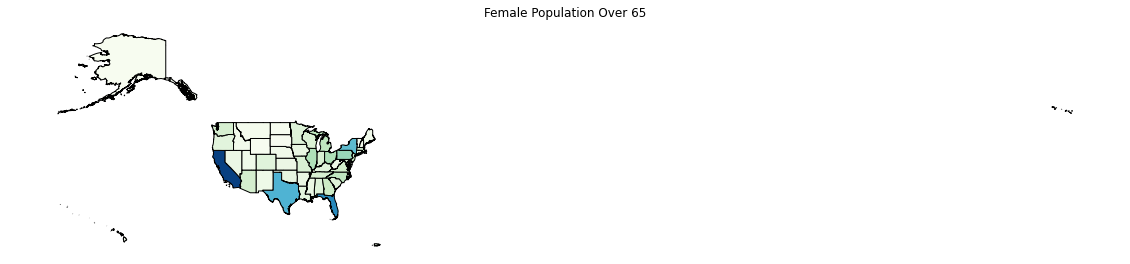

In [193]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'fo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'black',
                  ax = ax)
plt.title('Female Population Over 65', fontsize=12)
ax.axis('off');

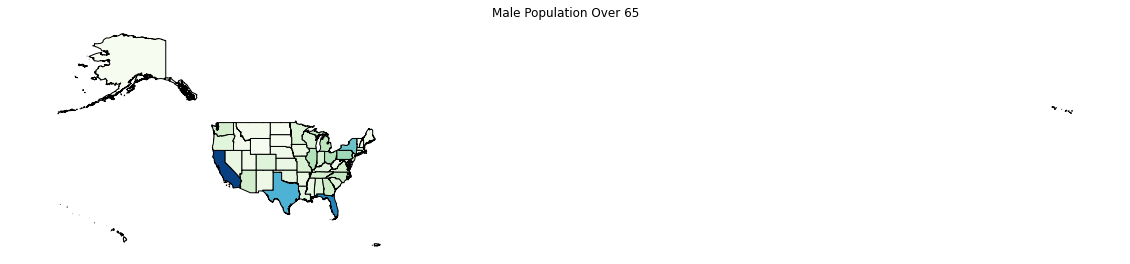

In [194]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'mo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'black',
                  ax = ax)
plt.title('Male Population Over 65', fontsize=12)
ax.axis('off');

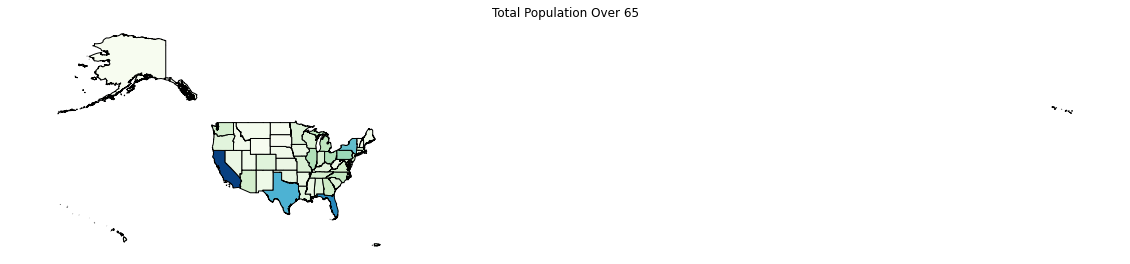

In [195]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'to65', 
                  cmap = 'GnBu', 
                  edgecolor = 'black',
                  ax = ax)
plt.title('Total Population Over 65', fontsize=12)
ax.axis('off');

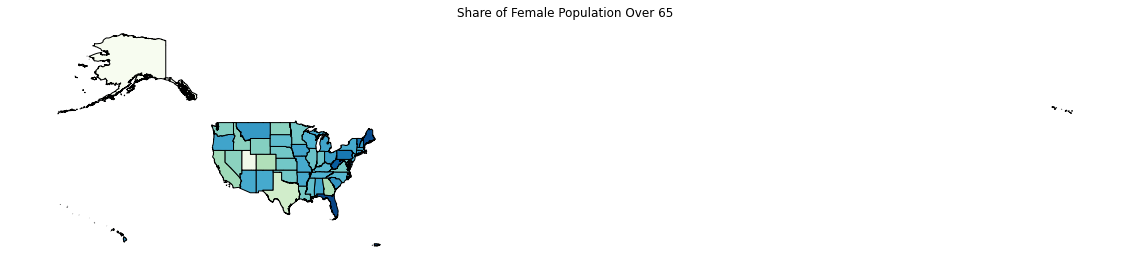

In [196]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'Pfo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'black',
                  ax = ax)
plt.title('Share of Female Population Over 65', fontsize=12)
ax.axis('off');

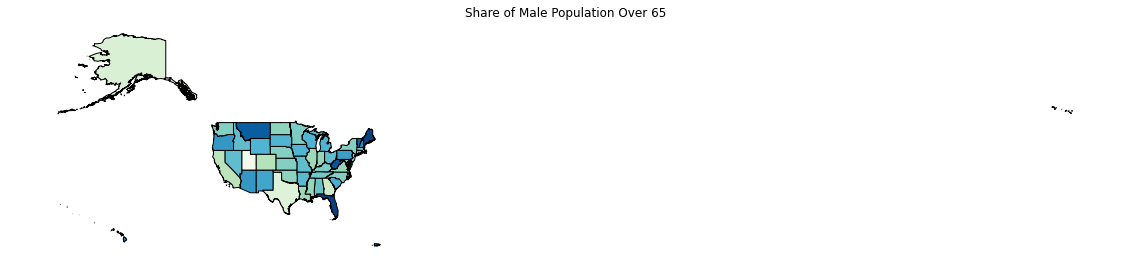

In [197]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'Pmo65', 
                  cmap = 'GnBu', 
                  edgecolor = 'black',
                  ax = ax)
plt.title('Share of Male Population Over 65', fontsize=12)
ax.axis('off');

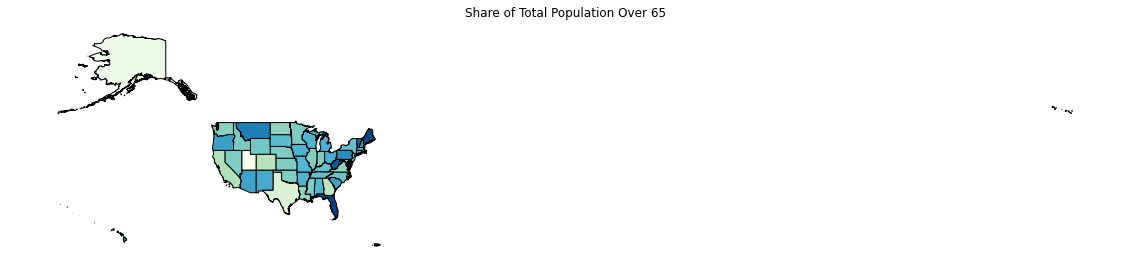

In [198]:
fig, ax = plt.subplots(figsize=(20,20))
agegroups_geo.plot(column = 'Pto65', 
                  cmap = 'GnBu', 
                  edgecolor = 'black',
                  ax = ax)
plt.title('Share of Total Population Over 65', fontsize=12)
ax.axis('off');